# Trabajo Práctico Final: Linear/Quadratic Discriminant Analysis (LDA/QDA)


### Definición: Clasificador Bayesiano

Sean $k$ poblaciones, $x \in \mathbb{R}^p$ puede pertenecer a cualquiera $g \in \mathcal{G}$ de ellas. Bajo un esquema bayesiano, se define entonces $\pi_j \doteq P(G = j)$ la probabilidad *a priori* de que $X$ pertenezca a la clase *j*, y se **asume conocida** la distribución condicional de cada observable dado su clase $f_j \doteq f_{X|G=j}$.

De esta manera dicha probabilidad *a posteriori* resulta
$$
P(G|_{X=x} = j) = \frac{f_{X|G=j}(x) \cdot p_G(j)}{f_X(x)} \propto f_j(x) \cdot \pi_j
$$

La regla de decisión de Bayes es entonces
$$
H(x) \doteq \arg \max_{g \in \mathcal{G}} \{ P(G|_{X=x} = j) \} = \arg \max_{g \in \mathcal{G}} \{ f_j(x) \cdot \pi_j \}
$$

es decir, se predice a $x$ como perteneciente a la población $j$ cuya probabilidad a posteriori es máxima.

*Ojo, a no desesperar! $\pi_j$ no es otra cosa que una constante prefijada, y $f_j$ es, en su esencia, un campo escalar de $x$ a simplemente evaluar.*

### Distribución condicional

Para los clasificadores de discriminante cuadrático y lineal (QDA/LDA) se asume que $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma_j)$, es decir, se asume que cada población sigue una distribución normal.

Por definición, se tiene entonces que para una clase $j$:
$$
f_j(x) = \frac{1}{(2 \pi)^\frac{p}{2} \cdot |\Sigma_j|^\frac{1}{2}} e^{- \frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)}
$$

Aplicando logaritmo (que al ser una función estrictamente creciente no afecta el cálculo de máximos/mínimos), queda algo mucho más práctico de trabajar:

$$
\log{f_j(x)} = -\frac{1}{2}\log |\Sigma_j| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C
$$

Observar que en este caso $C=-\frac{p}{2} \log(2\pi)$, pero no se tiene en cuenta ya que al tener una constante aditiva en todas las clases, no afecta al cálculo del máximo.

### LDA

En el caso de LDA se hace una suposición extra, que es $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma)$, es decir que las poblaciones no sólo siguen una distribución normal sino que son de igual matriz de covarianzas. Reemplazando arriba se obtiene entonces:

$$
\log{f_j(x)} =  -\frac{1}{2}\log |\Sigma| - \frac{1}{2} (x-\mu_j)^T \Sigma^{-1} (x- \mu_j) + C
$$

Ahora, como $-\frac{1}{2}\log |\Sigma|$ es común a todas las clases se puede incorporar a la constante aditiva y, distribuyendo y reagrupando términos sobre $(x-\mu_j)^T \Sigma^{-1} (x- \mu_j)$ se obtiene finalmente:

$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$

### Entrenamiento/Ajuste

Obsérvese que para ambos modelos, ajustarlos a los datos implica estimar los parámetros $(\mu_j, \Sigma_j) \; \forall j = 1, \dots, k$ en el caso de QDA, y $(\mu_j, \Sigma)$ para LDA.

Estos parámetros se estiman por máxima verosimilitud, de manera que los estimadores resultan:

* $\hat{\mu}_j = \bar{x}_j$ el promedio de los $x$ de la clase *j*
* $\hat{\Sigma}_j = s^2_j$ la matriz de covarianzas estimada para cada clase *j*
* $\hat{\pi}_j = f_{R_j} = \frac{n_j}{n}$ la frecuencia relativa de la clase *j* en la muestra
* $\hat{\Sigma} = \frac{1}{n} \sum_{j=1}^k n_j \cdot s^2_j$ el promedio ponderado (por frecs. relativas) de las matrices de covarianzas de todas las clases. *Observar que se utiliza el estimador de MV y no el insesgado*

Es importante notar que si bien todos los $\mu, \Sigma$ deben ser estimados, la distribución *a priori* puede no inferirse de los datos sino asumirse previamente, utilizándose como entrada del modelo.

### Predicción

Para estos modelos, al igual que para cualquier clasificador Bayesiano del tipo antes visto, la estimación de la clase es por método *plug-in* sobre la regla de decisión $H(x)$, es decir devolver la clase que maximiza $\hat{f}_j(x) \cdot \hat{\pi}_j$, o lo que es lo mismo $\log\hat{f}_j(x) + \log\hat{\pi}_j$.

## Estructura del código

## Modelo

In [1]:
import numpy as np
from numpy.linalg import det, inv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [2]:
class ClassEncoder:
  def fit(self, y):
    self.names = np.unique(y)
    self.name_to_class = {name:idx for idx, name in enumerate(self.names)}
    self.fmt = y.dtype
    # Q1: por que no hace falta definir un class_to_name para el mapeo inverso?

  def _map_reshape(self, f, arr):
    return np.array([f(elem) for elem in arr.flatten()]).reshape(arr.shape)
    # Q2: por que hace falta un reshape?

  def transform(self, y):
    return self._map_reshape(lambda name: self.name_to_class[name], y)

  def fit_transform(self, y):
    self.fit(y)
    return self.transform(y)

  def detransform(self, y_hat):
    return self._map_reshape(lambda idx: self.names[idx], y_hat)

In [3]:
class BaseBayesianClassifier:
  def __init__(self):
    self.encoder = ClassEncoder()

  def _estimate_a_priori(self, y):
    a_priori = np.bincount(y.flatten().astype(int)) / y.size
    # Q3: para que sirve bincount?
    return np.log(a_priori)

  def _fit_params(self, X, y):
    # estimate all needed parameters for given model
    raise NotImplementedError()

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    raise NotImplementedError()

  def fit(self, X, y, a_priori=None):
    # first encode the classes
    y = self.encoder.fit_transform(y)

    # if it's needed, estimate a priori probabilities
    self.log_a_priori = self._estimate_a_priori(y) if a_priori is None else np.log(a_priori)

    # check that a_priori has the correct number of classes
    assert len(self.log_a_priori) == len(self.encoder.names), "A priori probabilities do not match number of classes"

    # now that everything else is in place, estimate all needed parameters for given model
    self._fit_params(X, y)
    # Q4: por que el _fit_params va al final? no se puede mover a, por ejemplo, antes de la priori?

  def predict(self, X):
    # this is actually an individual prediction encased in a for-loop
    m_obs = X.shape[1]
    y_hat = np.empty(m_obs, dtype=self.encoder.fmt)

    for i in range(m_obs):
      encoded_y_hat_i = self._predict_one(X[:,i].reshape(-1,1))
      y_hat[i] = self.encoder.names[encoded_y_hat_i]

    # return prediction as a row vector (matching y)
    return y_hat.reshape(1,-1)

  def _predict_one(self, x):
    # calculate all log posteriori probabilities (actually, +C)
    log_posteriori = [ log_a_priori_i + self._predict_log_conditional(x, idx) for idx, log_a_priori_i
                  in enumerate(self.log_a_priori) ]

    # return the class that has maximum a posteriori probability
    return np.argmax(log_posteriori)

In [4]:
class QDA(BaseBayesianClassifier):

  def _fit_params(self, X, y):
    # estimate each covariance matrix
    self.inv_covs = [inv(np.cov(X[:,y.flatten()==idx], bias=True))
                      for idx in range(len(self.log_a_priori))]
    # Q5: por que hace falta el flatten y no se puede directamente X[:,y==idx]?
    # Q6: por que se usa bias=True en vez del default bias=False?
    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]
    # Q7: que hace axis=1? por que no axis=0?

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    inv_cov = self.inv_covs[class_idx]
    unbiased_x =  x - self.means[class_idx]
    return 0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x

In [5]:
class TensorizedQDA(QDA):

    def _fit_params(self, X, y):
        # ask plain QDA to fit params
        super()._fit_params(X,y)

        # stack onto new dimension
        self.tensor_inv_cov = np.stack(self.inv_covs)
        self.tensor_means = np.stack(self.means)

    def _predict_log_conditionals(self,x):
        unbiased_x = x - self.tensor_means
        inner_prod = unbiased_x.transpose(0,2,1) @ self.tensor_inv_cov @ unbiased_x

        return 0.5*np.log(det(self.tensor_inv_cov)) - 0.5 * inner_prod.flatten()

    def _predict_one(self, x):
        # return the class that has maximum a posteriori probability
        return np.argmax(self.log_a_priori + self._predict_log_conditionals(x))

## Código para pruebas

Seteamos los datos

In [6]:
# hiperparámetros
rng_seed = 6543

In [7]:
from sklearn.datasets import load_iris, fetch_openml

def get_iris_dataset():
  data = load_iris()
  X_full = data.data
  y_full = np.array([data.target_names[y] for y in data.target.reshape(-1,1)])
  return X_full, y_full

def get_penguins():
    # get data
    df, tgt = fetch_openml(name="penguins", return_X_y=True, as_frame=True, parser='auto')

    # drop non-numeric columns
    df.drop(columns=["island","sex"], inplace=True)

    # drop rows with missing values
    mask = df.isna().sum(axis=1) == 0
    df = df[mask]
    tgt = tgt[mask]

    return df.values, tgt.to_numpy().reshape(-1,1)

# showing for iris
X_full, y_full = get_iris_dataset()

print(f"X: {X_full.shape}, Y:{y_full.shape}")

X: (150, 4), Y:(150, 1)


In [8]:
# peek data matrix
X_full[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [9]:
# peek target vector
y_full[:5]

array([['setosa'],
       ['setosa'],
       ['setosa'],
       ['setosa'],
       ['setosa']], dtype='<U10')

Separamos el dataset en train y test para medir performance

In [10]:
# preparing data, train - test validation
# 70-30 split
from sklearn.model_selection import train_test_split

def split_transpose(X, y, test_sz=0.4, random_state=6543):
    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_sz, random_state=random_state)

    # transpose so observations are column vectors
    return X_train.T, y_train.T, X_test.T, y_test.T

def accuracy(y_true, y_pred):
  return (y_true == y_pred).mean()

train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(4, 90) (1, 90) (4, 60) (1, 60)


Entrenamos un QDA y medimos su accuracy

In [11]:
qda = QDA()

qda.fit(train_x, train_y)

In [12]:
train_acc = accuracy(train_y, qda.predict(train_x))
test_acc = accuracy(test_y, qda.predict(test_x))
print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

Train (apparent) error is 0.0111 while test error is 0.0167


Con el magic %%timeit podemos estimar el tiempo que tarda en correr una celda en base a varias ejecuciones. Por poner un ejemplo, acá vamos a estimar lo que tarda un ciclo completo de QDA y también su inferencia (predicción).

Ojo! a veces [puede ser necesario ejecutarlo varias veces](https://stackoverflow.com/questions/10994405/python-timeit-results-cached-instead-of-calculated) para obtener resultados consistentes.

Si quieren explorar otros métodos de medición también es válido!

In [13]:
%%timeit

qda.predict(test_x)

2.45 ms ± 146 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
%%timeit

model = QDA()
model.fit(train_x, train_y)
model.predict(test_x)

2.45 ms ± 8.75 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Consigna


## Implementación base
1. Entrenar un modelo QDA sobre el dataset *iris* utilizando las distribuciones *a priori* a continuación ¿Se observan diferencias?¿Por qué cree? _Pista: comparar con las distribuciones del dataset completo, **sin splitear**_.
    1. Uniforme (cada clase tiene probabilidad 1/3)
    2. Una clase con probabilidad 0.9, las demás 0.05 (probar las 3 combinaciones)
2. Repetir el punto anterior para el dataset *penguin*.
3. Implementar el modelo LDA, entrenarlo y testearlo contra los mismos sets que QDA (no múltiples prioris) ¿Se observan diferencias? ¿Podría decirse que alguno de los dos es notoriamente mejor que el otro?
4. Utilizar otros 2 (dos) valores de *random seed* para obtener distintos splits de train y test, y repetir la comparación del punto anterior ¿Las conclusiones previas se mantienen?
5. Estimar y comparar los tiempos de predicción de las clases `QDA` y `TensorizedQDA`. De haber diferencias ¿Cuáles pueden ser las causas?


**Sugerencia:** puede resultar de utilidad para cada inciso de comparación utilizar tablas del siguiente estilo:

<center>

Modelo | Dataset | Seed | Error (train) | Error (test)
:---: | :---: | :---: | :---: | :---:
QDA | Iris | 125 | 0.55 | 0.85
LDA | Iris | 125 | 0.22 | 0.8

</center>


## Optimización matemática

**Sugerencia:** considerar combinaciones adecuadas de `transpose`, `reshape` y, ocasionalmente, `flatten`. Explorar la dimensionalidad de cada elemento antes de implementar las clases.

### QDA

Debido a la forma cuadrática de QDA, no se puede predecir para *n* observaciones en una sola pasada (utilizar $X \in \mathbb{R}^{p \times n}$ en vez de $x \in \mathbb{R}^p$) sin pasar por una matriz de *n x n* en donde se computan todas las interacciones entre observaciones. Se puede acceder al resultado recuperando sólo la diagonal de dicha matriz, pero resulta ineficiente en tiempo y (especialmente) en memoria. Aún así, es *posible* que el modelo funcione más rápido.

1. Implementar el modelo `FasterQDA` (se recomienda heredarlo de TensorizedQDA) de manera de eliminar el ciclo for en el método predict.
2. Comparar los tiempos de predicción de `FasterQDA` con `TensorizedQDA` y `QDA`.
3. Mostrar (puede ser con un print) dónde aparece la mencionada matriz de *n x n*, donde *n* es la cantidad de observaciones a predecir.
4. Demostrar que
$$
diag(A \cdot B) = \sum_{cols} A \odot B^T = np.sum(A \odot B^T, axis=1)
$$ es decir, que se puede "esquivar" la matriz de *n x n* usando matrices de *n x p*.
5. Utilizar la propiedad antes demostrada para reimplementar la predicción del modelo `FasterQDA` de forma eficiente. ¿Hay cambios en los tiempos de predicción?


### LDA

1. "Tensorizar" el modelo LDA y comparar sus tiempos de predicción con el modelo antes implementado. *Notar que, en modo tensorizado, se puede directamente precomputar $\mu^T \cdot \Sigma^{-1} \in \mathbb{R}^{k \times 1 \times p}$ y guardar eso en vez de $\Sigma^{-1}$.*
2. LDA no sufre del problema antes descrito de QDA debido a que no computa productos internos, por lo que no tiene un verdadero costo extra en memoria predecir "en batch". Implementar el modelo `FasterLDA` y comparar sus tiempos de predicción con las versiones anteriores de LDA.

## Preguntas teóricas

1. En LDA se menciona que la función a maximizar puede ser, mediante operaciones, convertida en:
$$ \log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C' $$ 
Mostrar los pasos por los cuales se llega a dicha expresión.

2. Explicar, utilizando las respectivas funciones a maximizar, por qué QDA y LDA son "quadratic" y "linear".
3. La implementación de QDA estima la probabilidad condicional utilizando `0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x` que no es *exactamente* lo descrito en el apartado teórico ¿Cuáles son las diferencias y por qué son expresiones equivalentes?

El espíritu de esta componente práctica es la de establecer un mínimo de trabajo aceptable para su entrega; se invita al alumno a explorar otros aspectos que generen curiosidad, sin sentirse de ninguna manera limitado por la consigna.

## Ejercicio teórico

Sea una red neuronal de dos capas, la primera de 3 neuronas y la segunda de 1 con los parámetros inicializados con los siguientes valores:
$$
w^{(1)} =
\begin{pmatrix}
0.1 & -0.5 \\
-0.3 & -0.9 \\
0.8 & 0.02
\end{pmatrix},
b^{(1)} = \begin{pmatrix}
0.1 \\
0.5 \\
0.8
\end{pmatrix},
w^{(2)} =
\begin{pmatrix}
-0.4 & 0.2 & -0.5
\end{pmatrix},
b^{(2)} = 0.7
$$

y donde cada capa calcula su salida vía

$$
y^{(i)} = \sigma (w^{(i)} \cdot x^{(i)}+b^{(i)})
$$

donde $\sigma (z) = \frac{1}{1+e^{-z}}$ es la función sigmoidea .

\\
Dada la observación $x=\begin{pmatrix}
1.8 \\
-3.4
\end{pmatrix}$, $y=5$ y la función de costo $J(\theta)=\frac{1}{2}(\hat{y}_\theta-y)^2$, calcular las derivadas de J respecto de cada parámetro $w^{(1)}$, $w^{(2)}$, $b^{(1)}$, $b^{(2)}$.

*Nota: Con una sigmoidea a la salida jamás va a poder estimar el 5 "pedido", pero eso no afecta al mecanismo de backpropagation!*

## Preguntas en el código
Previamente las preguntas "técnicas" en comentarios en el código eran parte del TP, y buscaban que el alumno logre entrar en el detalle de por qué cada linea de código es como es y en el orden en el que está. Ya no forman parte de la consigna, pero se aconseja al alumno intentar responderlas. Las respuestas a las mismas se encuentran en un archivo separado.

# Resolución TP Final

## Implementación base

### 1. Entrenar un modelo QDA sobre el dataset *iris* utilizando las distribuciones *a priori* a continuación ¿Se observan diferencias?¿Por qué cree? 
Pista: comparar con las distribuciones del dataset completo, **sin splitear**.
1. Uniforme (cada clase tiene probabilidad 1/3)
2. Una clase con probabilidad 0.9, las demás 0.05 (probar las 3 combinaciones)

**Modelos**

- Modelo 1 | Dist. previa ( $\frac{1}{3}$ Setosa, $\frac{1}{3}$ Versicolor, $\frac{1}{3}$ Virginica)
- Modelo 2 | Dist. previa (**0.90 Setosa**, 0.05 Versicolor, 0.05 Virginica) 
- Modelo 3 | Dist. previa (0.05 Setosa, **0.90 Versicolor**, 0.05 Virginica)
- Modelo 4 | Dist. previa (0.05 Setosa, 0.05 Versicolor, **0.90 Virginica**)


 Target (y) (Iris) Dim.:(150, 1)
['setosa' 'versicolor' 'virginica'] 

[['setosa']
 ['setosa']
 ['setosa']
 ['setosa']
 ['setosa']]

 Features (X) (Iris) Dim.:(150, 4)
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'] 

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]


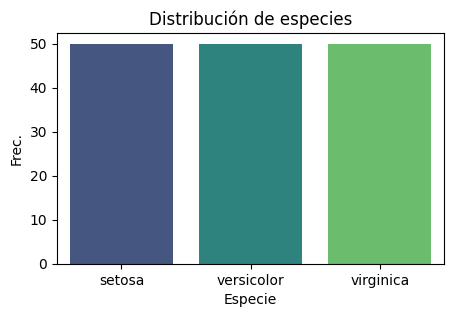

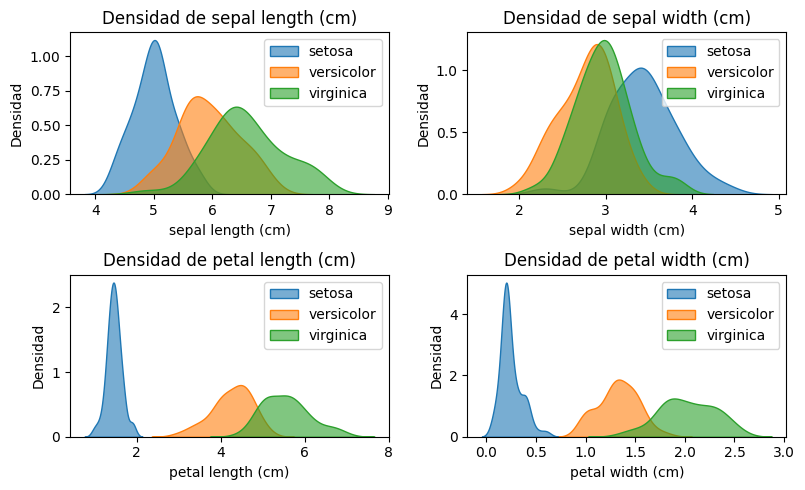

In [15]:
# ---------------- Carga | exploración de datos ----------------

names = load_iris().feature_names
X_full, y_full = get_iris_dataset()

# ---------------- Información del dataset ----------------

print(f'\n Target (y) (Iris) Dim.:{ y_full.shape}'); print(f'{np.unique(y_full)} \n') ;print(y_full[:5,])  
print(f'\n Features (X) (Iris) Dim.:{ X_full.shape}'); print(f'{names} \n') ;print(X_full[:5,])  

# ---------------- Gráficos ----------------

df_iris = pd.DataFrame(X_full, columns=load_iris().feature_names)
df_iris['species'] = y_full.flatten()

plt.figure(figsize=(5, 3))
sns.countplot(data=df_iris, x='species', palette='viridis' , hue='species')
plt.title('Distribución de especies')
plt.xlabel('Especie')
plt.ylabel('Frec.')
plt.show()

features = load_iris().feature_names
classes = df_iris['species'].unique()
    
plt.figure(figsize=(8, 5))
    
for i, feature in enumerate(features):
    plt.subplot(2, 2, i + 1)
    for cls in classes:
        subset = df_iris[df_iris['species'] == cls]
        sns.kdeplot(subset[feature], label=cls, fill=True, alpha=0.6)
    plt.title(f'Densidad de {feature}')
    plt.xlabel(feature)
    plt.ylabel('Densidad')
    plt.legend()

plt.tight_layout()    
plt.show()


In [16]:
# ---------------- Split datos entrenamiento (70%) | testeo (30%) ----------------

rng_seed = 44
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.3, rng_seed)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

print(np.unique(train_y, return_counts=True))
print(np.unique(test_y, return_counts=True))

(4, 105) (1, 105) (4, 45) (1, 45)
(array(['setosa', 'versicolor', 'virginica'], dtype='<U10'), array([33, 37, 35], dtype=int64))
(array(['setosa', 'versicolor', 'virginica'], dtype='<U10'), array([17, 13, 15], dtype=int64))


**Resumen de muestras de entrenamiento | test Iris**

Muestra | Setosa | Versicolor | Virginica
:---: | :---: | :---: | :---: 
Train | 33 | 37 | 35
Test | 17 | 13 | 15


In [17]:
# ---------------- Entrenamiento de los modelos ----------------

priors = [[1/3, 1/3, 1/3], [0.90, 0.05, 0.05], [0.05, 0.90, 0.05], [0.05, 0.05, 0.90]]

for i, a_priori in enumerate(priors, 1):
    qda_iris = QDA()
    qda_iris.fit(train_x, train_y, a_priori=a_priori)
    
    # Predicciones en conjunto de entrenamiento
    pred_train = qda_iris.predict(train_x)
    train_error = 1 - accuracy(train_y, pred_train)
    
    # Predicciones en conjunto de testeo
    pred_test = qda_iris.predict(test_x)
    test_error = 1 - accuracy(test_y, pred_test)
    
    print(f"Error de entrenamiento en modelo {i} es {train_error:.4f}, mientras que error en testeo es {test_error:.4f}")
    print(f'Prior: {a_priori}\n')

Error de entrenamiento en modelo 1 es 0.0190, mientras que error en testeo es 0.0000
Prior: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]

Error de entrenamiento en modelo 2 es 0.0190, mientras que error en testeo es 0.0000
Prior: [0.9, 0.05, 0.05]

Error de entrenamiento en modelo 3 es 0.0571, mientras que error en testeo es 0.0444
Prior: [0.05, 0.9, 0.05]

Error de entrenamiento en modelo 4 es 0.0476, mientras que error en testeo es 0.0000
Prior: [0.05, 0.05, 0.9]



**Resumen de modelos para Iris**

Modelo | Dataset | Seed | Priors |Error (train) | Error (test)
:---: | :---: | :---: | :---: | :---: | :---:
QDA | Iris | 44 | [1/3, 1/3, 1/3] | 0.0190 | 0.000
QDA | Iris | 44 | [**0.90**, 0.05, 0.05] | 0.0190 | 0.000
QDA | Iris | 44 | [0.05, **0.90**, 0.05] | 0.0571 | 0.0444
QDA | Iris | 44 | [0.05, 0.05, **0.90**] | 0.0476 | 0.0000


 Los priors asignados, que reflejan mejor la verdadera distribución de clases (modelo 1 y 2), tienden a presentar menores errores en ambos conjuntos. El hecho que los datos dentro del dataset (original) estén balanceados, favorece el caso del modelo 1 (donde se asigna una distribución previa de los datos *uniforme*).

### 2. Repetir el punto anterior para el dataset *penguin*.


 Target (y) (Penguin) Dim.:(342, 1)
['Adelie' 'Chinstrap' 'Gentoo'] 

[['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']]

 Features (X) (Penguin) Dim.:(342, 4)
['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g'] 

[[  39.1   18.7  181.  3750. ]
 [  39.5   17.4  186.  3800. ]
 [  40.3   18.   195.  3250. ]
 [  36.7   19.3  193.  3450. ]
 [  39.3   20.6  190.  3650. ]]


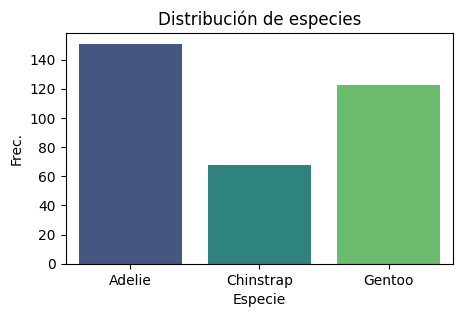

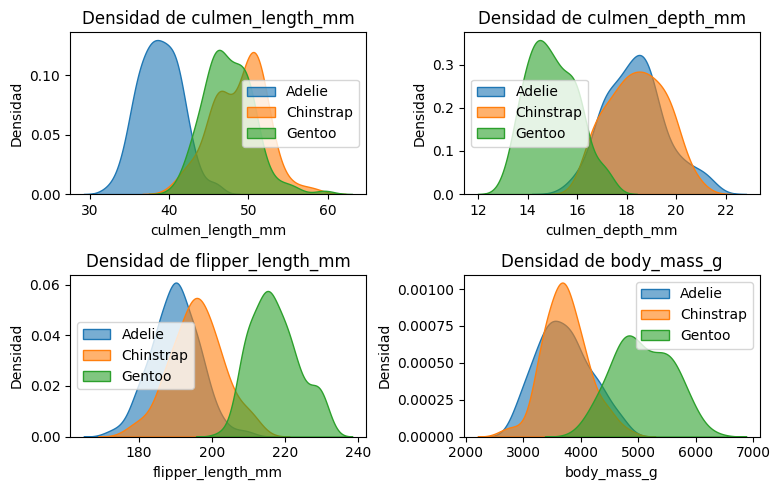

In [18]:
# ---------------- Carga | exploración de datos ----------------

names = ['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g']
X_fullp, y_fullp = get_penguins()

# ---------------- Información del dataset ----------------

print(f'\n Target (y) (Penguin) Dim.:{ y_fullp.shape}'); print(f'{np.unique(y_fullp)} \n') ;print(y_fullp[:5,])  
print(f'\n Features (X) (Penguin) Dim.:{ X_fullp.shape}'); print(f'{names} \n') ;print(X_fullp[:5,])  

# ---------------- Gráficos ----------------

df_peng = pd.DataFrame(X_fullp, columns=names)
df_peng['species'] = y_fullp.flatten()

plt.figure(figsize=(5, 3))
sns.countplot(data=df_peng, x='species', palette='viridis' , hue='species')
plt.title('Distribución de especies')
plt.xlabel('Especie')
plt.ylabel('Frec.')
plt.show()

features = names
classes = df_peng['species'].unique()
    
plt.figure(figsize=(8, 5))
    
for i, feature in enumerate(features):
    plt.subplot(2, 2, i + 1)
    for cls in classes:
        subset = df_peng[df_peng['species'] == cls]
        sns.kdeplot(subset[feature], label=cls, fill=True, alpha=0.6)
    plt.title(f'Densidad de {feature}')
    plt.xlabel(feature)
    plt.ylabel('Densidad')
    plt.legend()

plt.tight_layout()    
plt.show()

In [19]:
# ---------------- Split datos entrenamiento (70%) | testeo (30%) ----------------

rng_seed = 44
train_xp, train_yp, test_xp, test_yp = split_transpose(X_fullp, y_fullp, 0.3, rng_seed)
print(train_xp.shape, train_yp.shape, test_xp.shape, test_yp.shape)

print(np.unique(train_yp, return_counts=True))
print(np.unique(test_yp, return_counts=True))

(4, 239) (1, 239) (4, 103) (1, 103)
(array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object), array([108,  49,  82], dtype=int64))
(array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object), array([43, 19, 41], dtype=int64))


**Resumen de muestras de entrenamiento | test Penguins**

Muestra | Adelie | Chinstrap | Gentoo
:---: | :---: | :---: | :---: 
Train | 108 | 49 | 82
Test | 43 | 19 | 41


In [20]:
# ---------------- Entrenamiento de los modelos ----------------

# Distribuciones previas
priors = [[1/3, 1/3, 1/3], [0.90, 0.05, 0.05], [0.05, 0.90, 0.05], [0.05, 0.05, 0.90]]

for i, a_priori in enumerate(priors, 1):
    qda_peng = QDA()
    qda_peng.fit(train_xp, train_yp, a_priori=a_priori)
    
    # Predicciones en conjunto de entrenamiento
    pred_train = qda_peng.predict(train_xp); train_error = 1 - accuracy(train_yp, pred_train)
    
    # Predicciones en conjunto de testeo
    pred_test = qda_peng.predict(test_xp); test_error = 1 - accuracy(test_yp, pred_test)
    
    print(f"Error de entrenamiento en modelo {i} es {train_error:.4f}, mientras que error en testeo es {test_error:.4f}")
    print(f'Prior: {a_priori}\n')

Error de entrenamiento en modelo 1 es 0.0084, mientras que error en testeo es 0.0097
Prior: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]

Error de entrenamiento en modelo 2 es 0.0126, mientras que error en testeo es 0.0194
Prior: [0.9, 0.05, 0.05]

Error de entrenamiento en modelo 3 es 0.0418, mientras que error en testeo es 0.0583
Prior: [0.05, 0.9, 0.05]

Error de entrenamiento en modelo 4 es 0.0084, mientras que error en testeo es 0.0097
Prior: [0.05, 0.05, 0.9]



**Resumen de modelos para Penguin**

Modelo | Dataset | Seed | Priors |Error (train) | Error (test)
:---: | :---: | :---: | :---: | :---: | :---:
QDA | Penguin | 44 | [1/3, 1/3, 1/3] | 0.0084 | 0.0097
QDA | Penguin | 44 | [**0.90**, 0.05, 0.05] | 0.0126 | 0.0194
QDA | Penguin | 44 | [0.05, **0.90**, 0.05] | 0.0418 | 0.0583
QDA | Penguin | 44 | [0.05, 0.05, **0.90**] | 0.0084 | 0.0097

El modelo que presenta mayor error (tanto de entrenamiento, como de testeo), es el que le asigna una probabilidad previa más alta a la clase *chinstrap specie*, seguramente porque le asigna una probabilidad mayor al dato menos frecuente (de acuerdo distribución de las especies).

### 3. Implementar el modelo LDA, entrenarlo y testearlo contra los mismos sets que QDA (no múltiples prioris) ¿Se observan diferencias? ¿Podría decirse que alguno de los dos es notoriamente mejor que el otro?

In [21]:
class LDA(BaseBayesianClassifier):

    def _fit_params(self, X, y):
        cov_matrix = np.cov(X, bias=True) # Se cambia la matriz de covarianzas en QDA, por matriz única
        
        # Inversa de la matriz de covarianza
        self.inv_shared_cov = inv(cov_matrix) 

        # Calcular las medias por clase
        self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                      for idx in range(len(self.log_a_priori))]
        
    def _predict_log_conditional(self, x, class_idx):
        # Predecir el logaritmo de P(x|G=class_idx)
        unbiased_x =  x - self.means[class_idx]
        return -0.5 * unbiased_x.T @ self.inv_shared_cov @ unbiased_x

In [22]:
# ---------------- Split datos entrenamiento (70%) | testeo (30%) ----------------

rng_seed = 44
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.3, rng_seed)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)


# ---------------- QDA Iris ----------------

qda_iris = QDA()
qda_iris.fit(train_x, train_y)
    
# Predicciones en conjunto de entrenamiento
pred_train = qda_iris.predict(train_x); train_error = 1 - accuracy(train_y, pred_train)
    
# Predicciones en conjunto de testeo
pred_test = qda_iris.predict(test_x); test_error = 1 - accuracy(test_y, pred_test)
    
print(f"Error de entrenamiento en modelo QDA es {train_error:.4f}, mientras que error en testeo es {test_error:.4f}")


# ---------------- LDA Iris ----------------

lda_iris = LDA()
lda_iris.fit(train_x, train_y)
    
# Predicciones en conjunto de entrenamiento
pred_train = lda_iris.predict(train_x); train_error = 1 - accuracy(train_y, pred_train)
    
# Predicciones en conjunto de testeo
pred_test = lda_iris.predict(test_x); test_error = 1 - accuracy(test_y, pred_test)
    
print(f"Error de entrenamiento en modelo LDA es {train_error:.4f}, mientras que error en testeo es {test_error:.4f}")

(4, 105) (1, 105) (4, 45) (1, 45)
Error de entrenamiento en modelo QDA es 0.0190, mientras que error en testeo es 0.0000
Error de entrenamiento en modelo LDA es 0.1714, mientras que error en testeo es 0.1778


**Resultados QDA | LDA en dataset "Iris"**

Modelo | Dataset | Seed | Error (train) | Error (test)
:---: | :---: | :---: |  :---: | :---:
QDA | Iris | 44 |  0.0190 | 0.0000
LDA | Iris | 44 |  0.1714 | 0.1778

En el caso del dataset de Iris, se observan diferencias a favor del QDA, dado que (en principio) presenta menor error tanto de entrenamiento como de testeo. Por lo tanto, el flexibilizar la varianza de cada una de las especies clases (que es lo que efectivamente hace QDA), parece ser una mejor opción para adaptarse a los datos (mientras que LDA no parece ni ajusta ni generalizar bien en este caso). 

In [23]:
# ---------------- Split datos entrenamiento (70%) | testeo (30%) ----------------

rng_seed = 44
train_xp, train_yp, test_xp, test_yp = split_transpose(X_fullp, y_fullp, 0.3, rng_seed)
print(train_xp.shape, train_yp.shape, test_xp.shape, test_yp.shape)


# ---------------- QDA ----------------

qda_peng = QDA()
qda_peng.fit(train_xp, train_yp)
    
# Predicciones en conjunto de entrenamiento
pred_train = qda_peng.predict(train_xp); train_error = 1 - accuracy(train_yp, pred_train)
    
# Predicciones en conjunto de testeo
pred_test = qda_peng.predict(test_xp); test_error = 1 - accuracy(test_yp, pred_test)
    
print(f"Error de entrenamiento en modelo QDA es {train_error:.4f}, mientras que error en testeo es {test_error:.4f}")


# ---------------- LDA ----------------

lda_peng = LDA()
lda_peng.fit(train_xp, train_yp)
    
# Predicciones en conjunto de entrenamiento
pred_train = lda_peng.predict(train_xp); train_error = 1 - accuracy(train_yp, pred_train)
    
# Predicciones en conjunto de testeo
pred_test = lda_peng.predict(test_xp); test_error = 1 - accuracy(test_yp, pred_test)
    
print(f"Error de entrenamiento en modelo LDA es {train_error:.4f}, mientras que error en testeo es {test_error:.4f}")

(4, 239) (1, 239) (4, 103) (1, 103)
Error de entrenamiento en modelo QDA es 0.0126, mientras que error en testeo es 0.0097
Error de entrenamiento en modelo LDA es 0.0209, mientras que error en testeo es 0.0194


**Resultados QDA | LDA en dataset "Penguins"**

Modelo | Dataset | Seed | Error (train) | Error (test)
:---: | :---: | :---: |  :---: | :---:
QDA | Penguins | 44 |  0.0126 | 0.0097
LDA | Penguins | 44 |  0.0209 | 0.0194

En el caso del dataset de Penguins, se observan diferencias a favor del QDA, dado que presenta menor error tanto de entrenamiento como de testeo. Por lo tanto, el flexibilizar la varianza de cada una de las especies clases (que es lo que efectivamente hace QDA), parece ser una mejor opción para adaptarse a los datos (mientras que LDA no parece ni ajusta ni generalizar bien en este caso).

### 4. Utilizar otros 2 (dos) valores de *random seed* para obtener distintos splits de train y test, y repetir la comparación del punto anterior ¿Las conclusiones previas se mantienen?

In [24]:
# ---------------- Split datos entrenamiento (70%) | testeo (30%) ----------------

rng_seed = 1001
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.3, rng_seed)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
print(np.unique(train_y, return_counts=True))
print(np.unique(test_y, return_counts=True))


# ---------------- QDA Iris ----------------

qda_iris = QDA()
qda_iris.fit(train_x, train_y)
    
# Predicciones en conjunto de entrenamiento
pred_train = qda_iris.predict(train_x); train_error = 1 - accuracy(train_y, pred_train)
    
# Predicciones en conjunto de testeo
pred_test = qda_iris.predict(test_x); test_error = 1 - accuracy(test_y, pred_test)
    
print(f"Error de entrenamiento en modelo QDA, con semilla {rng_seed} es {train_error:.4f}, mientras que error en testeo es {test_error:.4f}")


# ---------------- LDA Iris ----------------

lda_iris = LDA()
lda_iris.fit(train_x, train_y)
    
# Predicciones en conjunto de entrenamiento
pred_train = lda_iris.predict(train_x); train_error = 1 - accuracy(train_y, pred_train)
    
# Predicciones en conjunto de testeo
pred_test = lda_iris.predict(test_x); test_error = 1 - accuracy(test_y, pred_test)
    
print(f"Error de entrenamiento en modelo LDA, con semilla {rng_seed} es {train_error:.4f}, mientras que error en testeo es {test_error:.4f}")


# ---------------- Split datos entrenamiento (70%) | testeo (30%) ----------------

rng_seed = 4444
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.3, rng_seed)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
print(np.unique(train_y, return_counts=True))
print(np.unique(test_y, return_counts=True))


# ---------------- QDA Iris ----------------

qda_iris = QDA()
qda_iris.fit(train_x, train_y)
    
# Predicciones en conjunto de entrenamiento
pred_train = qda_iris.predict(train_x); train_error = 1 - accuracy(train_y, pred_train)
    
# Predicciones en conjunto de testeo
pred_test = qda_iris.predict(test_x); test_error = 1 - accuracy(test_y, pred_test)
    
print(f"Error de entrenamiento en modelo QDA, con semilla {rng_seed} es {train_error:.4f}, mientras que error en testeo es {test_error:.4f}")


# ---------------- LDA Iris ----------------

lda_iris = LDA()
lda_iris.fit(train_x, train_y)
    
# Predicciones en conjunto de entrenamiento
pred_train = lda_iris.predict(train_x); train_error = 1 - accuracy(train_y, pred_train)
    
# Predicciones en conjunto de testeo
pred_test = lda_iris.predict(test_x); test_error = 1 - accuracy(test_y, pred_test)
    
print(f"Error de entrenamiento en modelo LDA, con semilla {rng_seed} es {train_error:.4f}, mientras que error en testeo es {test_error:.4f}")


(4, 105) (1, 105) (4, 45) (1, 45)
(array(['setosa', 'versicolor', 'virginica'], dtype='<U10'), array([38, 33, 34], dtype=int64))
(array(['setosa', 'versicolor', 'virginica'], dtype='<U10'), array([12, 17, 16], dtype=int64))
Error de entrenamiento en modelo QDA, con semilla 1001 es 0.0286, mientras que error en testeo es 0.0000
Error de entrenamiento en modelo LDA, con semilla 1001 es 0.1238, mientras que error en testeo es 0.2000
(4, 105) (1, 105) (4, 45) (1, 45)
(array(['setosa', 'versicolor', 'virginica'], dtype='<U10'), array([40, 30, 35], dtype=int64))
(array(['setosa', 'versicolor', 'virginica'], dtype='<U10'), array([10, 20, 15], dtype=int64))
Error de entrenamiento en modelo QDA, con semilla 4444 es 0.0381, mientras que error en testeo es 0.0444
Error de entrenamiento en modelo LDA, con semilla 4444 es 0.1143, mientras que error en testeo es 0.2667


**Resumen de muestras de entrenamiento | test "Iris"**

Muestra | Dataset | seed | Setosa | Versicolor | Virginica
:---: | :---: | :---: | :---: | :---: | :---: 
Train | Iris | 44 | 33 | 37 | 35
Test | Iris | 44 | 17 | 13 | 15
Train | Iris | 1001 | 38 | 33 | 34
Test | Iris | 1001 | 12 | 17 | 16
Train | Iris | 4444 | 40 | 30 | 35
Test | Iris | 4444 | 10 | 20 | 15

**Resultados QDA | LDA en dataset "Iris"**

Modelo | Dataset | Seed | Error (train) | Error (test)
:---: | :---: | :---: |  :---: | :---:
QDA | Iris | 44 |  0.0190 | 0.0000
LDA | Iris | 44 |   0.1714 |  0.1778 
QDA | Iris | 1001 |  0.0286 | 0.0000
LDA | Iris | 1001 |  0.1238 | 0.2000
QDA | Iris | 4444 |  0.0381 | 0.0444
LDA | Iris | 4444 |  0.1143 | 0.2667

En el caso del dataset de Iris, se mantiene el mismo patrón mas allá de variar la semilla, por lo que la aleatoriedad no afecta la elección de un modelo sobre el otro. QDA sigue manteniendo mejor ajuste (menor error de entrenamiento) y mejor generalización (menor error de testeo), con respecto LDA, en cada caso.

In [25]:
# ---------------- Split datos entrenamiento (70%) | testeo (30%) Semilla 1001 ----------------

rng_seed = 1001
train_xp, train_yp, test_xp, test_yp = split_transpose(X_fullp, y_fullp, 0.3, rng_seed)
print(train_xp.shape, train_yp.shape, test_xp.shape, test_yp.shape)
print(np.unique(train_yp, return_counts=True))
print(np.unique(test_yp, return_counts=True))


# ---------------- QDA Penguin ----------------

qda_peng = QDA()
qda_peng.fit(train_xp, train_yp)
    
# Predicciones en conjunto de entrenamiento
pred_train = qda_peng.predict(train_xp); train_error = 1 - accuracy(train_yp, pred_train)
    
# Predicciones en conjunto de testeo
pred_test = qda_peng.predict(test_xp); test_error = 1 - accuracy(test_yp, pred_test)
    
print(f"Error de entrenamiento en modelo QDA, con semilla {rng_seed} es {train_error:.4f}, mientras que error en testeo es {test_error:.4f}")


# ---------------- LDA Penguin ----------------

lda_peng = LDA()
lda_peng.fit(train_xp, train_yp)
    
# Predicciones en conjunto de entrenamiento
pred_train = lda_peng.predict(train_xp); train_error = 1 - accuracy(train_yp, pred_train)
    
# Predicciones en conjunto de testeo
pred_test = lda_peng.predict(test_xp); test_error = 1 - accuracy(test_yp, pred_test)
    
print(f"Error de entrenamiento en modelo LDA, con semilla {rng_seed} es {train_error:.4f}, mientras que error en testeo es {test_error:.4f}")


# ---------------- Split datos entrenamiento (70%) | testeo (30%) Semilla 4444 ----------------

rng_seed = 4444
train_xp, train_yp, test_xp, test_yp = split_transpose(X_fullp, y_fullp, 0.3, rng_seed)
print(train_xp.shape, train_yp.shape, test_xp.shape, test_yp.shape)
print(np.unique(train_yp, return_counts=True))
print(np.unique(test_yp, return_counts=True))


# ---------------- QDA Penguin ----------------

qda_peng = QDA()
qda_peng.fit(train_xp, train_yp)
    
# Predicciones en conjunto de entrenamiento
pred_train = qda_peng.predict(train_xp); train_error = 1 - accuracy(train_yp, pred_train)
    
# Predicciones en conjunto de testeo
pred_test = qda_peng.predict(test_xp); test_error = 1 - accuracy(test_yp, pred_test)
    
print(f"Error de entrenamiento en modelo QDA, con semilla {rng_seed} es {train_error:.4f}, mientras que error en testeo es {test_error:.4f}")


# ---------------- LDA Penguin ----------------

lda_peng = LDA()
lda_peng.fit(train_xp, train_yp)
    
# Predicciones en conjunto de entrenamiento
pred_train = lda_peng.predict(train_xp); train_error = 1 - accuracy(train_yp, pred_train)
    
# Predicciones en conjunto de testeo
pred_test = lda_peng.predict(test_xp); test_error = 1 - accuracy(test_yp, pred_test)
    
print(f"Error de entrenamiento en modelo LDA, con semilla {rng_seed} es {train_error:.6f}, mientras que error en testeo es {test_error:.6f}")

(4, 239) (1, 239) (4, 103) (1, 103)
(array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object), array([105,  44,  90], dtype=int64))
(array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object), array([46, 24, 33], dtype=int64))
Error de entrenamiento en modelo QDA, con semilla 1001 es 0.0042, mientras que error en testeo es 0.0388
Error de entrenamiento en modelo LDA, con semilla 1001 es 0.0084, mientras que error en testeo es 0.0485
(4, 239) (1, 239) (4, 103) (1, 103)
(array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object), array([107,  48,  84], dtype=int64))
(array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object), array([44, 20, 39], dtype=int64))
Error de entrenamiento en modelo QDA, con semilla 4444 es 0.0126, mientras que error en testeo es 0.0097
Error de entrenamiento en modelo LDA, con semilla 4444 es 0.020921, mientras que error en testeo es 0.019417


**Resumen de muestras de entrenamiento | test "Penguins"**

Muestra | Dataset | seed | Adelie | Chinstrap | Gentoo
:---: | :---: | :---: | :---: | :---: | :---: 
Train | Penguins | 44 | 108 | 49 | 82
Test | Penguins | 44 | 43 | 19 | 41
Train | Penguins | 1001 | 105 | 44 | 90
Test | Penguins | 1001 | 46 | 24 | 33
Train | Penguins | 4444 | 107 | 48 | 84
Test | Penguins | 4444 | 44 | 20 | 39

**Resultados QDA | LDA en dataset "Penguins"**

Modelo | Dataset | Seed | Error (train) | Error (test)
:---: | :---: | :---: |  :---: | :---:
QDA | Penguins | 44 |  0.0126 | 0.0097
LDA | Penguins | 44 |  0.0209 | 0.0194
QDA | Penguin | 1001 |  0.0042 | 0.0388
LDA | Penguin | 1001 |  0.0084 | 0.0485
QDA | Penguin | 4444 |  0.0126 | 0.0097
LDA | Penguin | 4444 |  0.0209 | 0.0194

Al variar la semilla, se toman varias muestras (dado que la semilla fijaba la aleatoriedad de la muestra que se toma, afecta el *split*), y se pueden detectar varias diferencias a favor del modelo QDA, tanto en el ajuste del modelo (error de entrenamiento) como en la generalización del mismo (error de testeo). Esto seguramente se deba al *desbalance* que puede existir dentro de los datos utilizados para entrenar el modelo (i.e. hay especies con mayor frecuencia que otras, por lo tanto es susceptible a la muestra tomada).

### 5. Estimar y comparar los tiempos de predicción de las clases `QDA` y `TensorizedQDA`. De haber diferencias ¿Cuáles pueden ser las causas?

In [26]:
'''class QDA(BaseBayesianClassifier):

  def _fit_params(self, X, y):
    # estimate each covariance matrix
    self.inv_covs = [inv(np.cov(X[:,y.flatten()==idx], bias=True))
                      for idx in range(len(self.log_a_priori))]
    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    inv_cov = self.inv_covs[class_idx]
    unbiased_x =  x - self.means[class_idx]
    return 0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x
    
    
class TensorizedQDA(QDA):

    def _fit_params(self, X, y):
        # ask plain QDA to fit params
        super()._fit_params(X,y)

        # stack onto new dimension
        self.tensor_inv_cov = np.stack(self.inv_covs)
        self.tensor_means = np.stack(self.means)

    def _predict_log_conditionals(self,x):
        unbiased_x = x - self.tensor_means
        inner_prod = unbiased_x.transpose(0,2,1) @ self.tensor_inv_cov @ unbiased_x

        return 0.5*np.log(det(self.tensor_inv_cov)) - 0.5 * inner_prod.flatten()

    def _predict_one(self, x):
        # return the class that has maximum a posteriori probability
        return np.argmax(self.log_a_priori + self._predict_log_conditionals(x))    
    
'''



'class QDA(BaseBayesianClassifier):\n\n  def _fit_params(self, X, y):\n    # estimate each covariance matrix\n    self.inv_covs = [inv(np.cov(X[:,y.flatten()==idx], bias=True))\n                      for idx in range(len(self.log_a_priori))]\n    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)\n                  for idx in range(len(self.log_a_priori))]\n\n  def _predict_log_conditional(self, x, class_idx):\n    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class\n    # this should depend on the model used\n    inv_cov = self.inv_covs[class_idx]\n    unbiased_x =  x - self.means[class_idx]\n    return 0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x\n    \n    \nclass TensorizedQDA(QDA):\n\n    def _fit_params(self, X, y):\n        # ask plain QDA to fit params\n        super()._fit_params(X,y)\n\n        # stack onto new dimension\n        self.tensor_inv_cov = np.stack(self.inv_covs)\n        self.tensor_

In [27]:
# ---------------- Split datos entrenamiento (70%) | testeo (30%) ----------------

rng_seed = 44
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.3, rng_seed)

# ---------------- QDA Iris ----------------

qda_iris = QDA()
qda_iris.fit(train_x, train_y)

# ---------------- TensorizedQDA Iris ----------------

tqda_iris = TensorizedQDA()
tqda_iris.fit(train_x, train_y)
    

In [28]:
%%timeit -n 1000 -r 10
#  ---------------- Tiempos de predicción QDA Iris ----------------
qda_iris.predict(test_x)

1.75 ms ± 24.7 μs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)


In [29]:
%%timeit -n 1000 -r 10
#  ---------------- Tiempos de predicción Tensorized QDA Iris ----------------
tqda_iris.predict(test_x)

629 μs ± 11.5 μs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)


Modelo | Tiempo Medio ($\mu s$)| Desvío ($\mu s$) |
:---: | :---: | :---: | 
QDA | 1700 | 66.3 | 
TQDA | 664 | 14.6 | 


La versión *no tensorizada* utiliza el bucle for y eso aumentaría la complejidad computacional, en cambio la *tensorizada* al realizar cálculos con tensores, disminuye la complejidad computacional y se aprovechan de forma más eficiente los recursos disponibles (e.g. *cpu, gpu*). En este caso, TensorizedQDA toma $\approx$ un $39,1 \% $ del tiempo que demora QDA en generar la predicción.

## Optimización matemática

**Sugerencia:** considerar combinaciones adecuadas de `transpose`, `reshape` y, ocasionalmente, `flatten`. Explorar la dimensionalidad de cada elemento antes de implementar las clases.

### QDA

Debido a la forma cuadrática de QDA, no se puede predecir para *n* observaciones en una sola pasada (utilizar $X \in \mathbb{R}^{p \times n}$ en vez de $x \in \mathbb{R}^p$) sin pasar por una matriz de *n x n* en donde se computan todas las interacciones entre observaciones. Se puede acceder al resultado recuperando sólo la diagonal de dicha matriz, pero resulta ineficiente en tiempo y (especialmente) en memoria. Aún así, es *posible* que el modelo funcione más rápido.

1. Implementar el modelo `FasterQDA` (se recomienda heredarlo de TensorizedQDA) de manera de eliminar el ciclo for en el método predict.

In [30]:
import numpy as np
from numpy.linalg import inv, det
#from BaseBayesianClassifier import BaseBayesianClassifier

class FasterQDA(TensorizedQDA):
    
    def predict(self, X):
        predictions = np.argmax((self.log_a_priori.reshape(-1,1) + self._predict_log_conditionals(X)).T,axis=1)
        
        return self.encoder.names[predictions].reshape(1,-1)        

    def _predict_log_conditionals(self, X):
        unbiased_X = X - self.tensor_means
        inner_prod = unbiased_X.transpose(0,2,1) @ self.tensor_inv_cov @ unbiased_X
        diag_inner_prod = np.diagonal(inner_prod, axis1=1, axis2=2)
        return 0.5 * np.log(det(self.tensor_inv_cov)).reshape(-1,1) - 0.5 * diag_inner_prod

2. Comparar los tiempos de predicción de `FasterQDA` con `TensorizedQDA` y `QDA`.

In [31]:
# ---------------- Split datos entrenamiento (70%) | testeo (30%) ----------------

rng_seed = 1001
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.3, rng_seed)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(4, 105) (1, 105) (4, 45) (1, 45)


In [32]:
# ---------------- QDA Iris ----------------

qda_iris = QDA()
qda_iris.fit(train_x, train_y)

# ---------------- Tensorized QDA Iris ----------------

tensorized_qda_iris = TensorizedQDA()
tensorized_qda_iris.fit(train_x, train_y)

# ---------------- FasterQDA Iris ----------------

faster_qda_iris = FasterQDA()
faster_qda_iris.fit(train_x, train_y)

In [33]:
%%timeit -n 1000 -r 10
# ---------------- Tiempos de predicción QDA en conjunto de testeo ----------------
qda_iris_pred_test = qda_iris.predict(test_x)

1.69 ms ± 12.5 μs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)


In [34]:
%%timeit -n 1000 -r 10
# ---------------- Tiempos de predicción TensorizedQDA en conjunto de testeo ----------------
tensorized_qda_iris_pred_test = tensorized_qda_iris.predict(test_x)

645 μs ± 14.8 μs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)


In [35]:
%%timeit -n 1000 -r 10
# ---------------- Tiempos de predicción FasterQDA en conjunto de testeo ----------------
faster_qda_iris_pred_test = faster_qda_iris.predict(test_x)

28.2 μs ± 5.38 μs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)


Modelo | Tiempo Medio ($\mu s$)| Desvío ($\mu s$) |
:---: | :---: | :---: | 
QDA | 1710 | 79.7 | 
TQDA | 737 | 15 | 
FQDA | 26 | 2.29 | 



3. Mostrar (puede ser con un print) dónde aparece la mencionada matriz de *n x n*, donde *n* es la cantidad de observaciones a predecir.

La matriz de 𝑛×𝑛 aparece cuando se calcula el producto interno en el método _predict_log_conditionals de la clase TensorizedQDA. La operación que genera una matriz 
𝑛 × 𝑛 es:

In [36]:
# inner_prod = unbiased_x.transpose(0, 2, 1) @ self.tensor_inv_cov @ unbiased_x

4.Demostrar que
$$
diag(A \cdot B) = \sum_{cols} A \odot B^T = np.sum(A \odot B^T, axis=1)
$$ es decir, que se puede "esquivar" la matriz de *n x n* usando matrices de *n x p*.

In [37]:
A = np.random.randn(100, 10)
B = np.random.randn(10, 100)

# Producto matriz-matriz
producto = A @ B

# Diagonal del producto
diagonal_producto = np.diag(producto)

# Demostración de la propiedad
producto_elementwise = A * B.T
suma_producto_elementwise = np.sum(producto_elementwise, axis=1)

# Comprobación
np.allclose(diagonal_producto, suma_producto_elementwise)


True

Empezamos planteando $A \cdot B$
$$ A \cdot B =
\begin{bmatrix}
    \sum_{i=1}^n a_{1i}b_{i1} & \sum_{i=1}^n a_{1i}b_{i2} & \cdots \\
    \sum_{i=1}^n a_{2i}b_{i1} & \sum_{i=1}^n a_{2i}b_{i2} & \cdots \\
    \vdots & \vdots & \ddots 
\end{bmatrix} $$
Tomando la diagonal de esta matriz obtenemos
$$diag(A \cdot B) =\begin{bmatrix}\sum_{i=1}^n a_{1i}b_{i1} \\ \sum_{i=1}^n a_{2i}b_{i2} \\ \vdots\end{bmatrix}$$

Por otro lado, haciendo el producto elemento a elemento de $A \odot B^T$ tenemos
$$ A \odot B =
\begin{bmatrix}
    a_{11}b_{11} & a_{12}b_{21} & \cdots & a_{1k}b_{k1} & \cdots \\
    a_{21}b_{12} & a_{22}b_{22} & \cdots & \cdots & \cdots \\
    \vdots & \vdots & \ddots & & \\
    a_{k1}b_{1k} & \vdots & & \ddots & \\
    \vdots & \vdots & & & \ddots \\
\end{bmatrix} $$
Y sumando de forma horizontal, todas las columnas, se obtiene
$$\sum_{cols} A \odot B^T =\begin{bmatrix}
    \sum_{i=1}^n a_{1i}b_{i1} \\ \sum_{i=1}^n a_{2i}b_{i2} \\ \vdots
\end{bmatrix}$$

5.Utilizar la propiedad antes demostrada para reimplementar la predicción del modelo `FasterQDA` de forma eficiente. ¿Hay cambios en los tiempos de predicción?

In [38]:
class FasterQDA(TensorizedQDA):

    def predict(self, X):
        predictions = np.argmax((self.log_a_priori.reshape(-1,1) + self._predict_log_conditionals(X)).T,axis=1)
        
        return self.encoder.names[predictions].reshape(1,-1)        

    def _predict_log_conditionals(self, X):
        unbiased_X = X - self.tensor_means
        prod = unbiased_X.transpose(0,2,1) @ self.tensor_inv_cov
        sum_inner_prod = np.sum(prod * unbiased_X.transpose(0,2,1), axis=2) # Flag
        return 0.5 * np.log(det(self.tensor_inv_cov)).reshape(-1,1) - 0.5 * sum_inner_prod


In [39]:
# ---------------- Split datos entrenamiento (70%) | testeo (30%) ----------------

rng_seed = 1001
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.3, rng_seed)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

# ---------------- FasterQDA Iris ----------------

faster_qda_iris = FasterQDA()
faster_qda_iris.fit(train_x, train_y)

(4, 105) (1, 105) (4, 45) (1, 45)


In [40]:
%%timeit -n 1000 -r 10

# ---------------- Tiempos de predicción FasterQDA en conjunto de testeo ----------------

faster_qda_iris_pred_test = faster_qda_iris.predict(test_x)

25.8 μs ± 1.14 μs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)


Modelo | Tiempo Medio ($\mu s$)| Desvío ($\mu s$) |
:---: | :---: | :---: | 
FQDA | 26 | 2.29 | 
New FQDA | 24.8 | 1.62 | 


### LDA

1. "Tensorizar" el modelo LDA y comparar sus tiempos de predicción con el modelo antes implementado. *Notar que, en modo tensorizado, se puede directamente precomputar $\mu^T \cdot \Sigma^{-1} \in \mathbb{R}^{k \times 1 \times p}$ y guardar eso en vez de $\Sigma^{-1}$.*

In [41]:
''' Código Implementado LDA


class LDA(BaseBayesianClassifier):

    def _fit_params(self, X, y):
        cov_matrix = np.cov(X, bias=True) # Se cambia la matriz de covarianzas en QDA, por matriz única
        
        # Inversa de la matriz de covarianza
        self.inv_shared_cov = inv(cov_matrix) 

        # Calcular las medias por clase
        self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                      for idx in range(len(self.log_a_priori))]
        
    def _predict_log_conditional(self, x, class_idx):
        # Predecir el logaritmo de P(x|G=class_idx)
        unbiased_x =  x - self.means[class_idx]
        return -0.5 * unbiased_x.T @ self.inv_shared_cov @ unbiased_x
        
'''

' Código Implementado LDA\n\n\nclass LDA(BaseBayesianClassifier):\n\n    def _fit_params(self, X, y):\n        cov_matrix = np.cov(X, bias=True) # Se cambia la matriz de covarianzas en QDA, por matriz única\n        \n        # Inversa de la matriz de covarianza\n        self.inv_shared_cov = inv(cov_matrix) \n\n        # Calcular las medias por clase\n        self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)\n                      for idx in range(len(self.log_a_priori))]\n        \n    def _predict_log_conditional(self, x, class_idx):\n        # Predecir el logaritmo de P(x|G=class_idx)\n        unbiased_x =  x - self.means[class_idx]\n        return -0.5 * unbiased_x.T @ self.inv_shared_cov @ unbiased_x\n        \n'

Función a maximizar:
$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$

In [42]:
import time

# TensorizedLDA class
class TensorizedLDA(LDA):

    def _fit_params(self, X, y):
        super()._fit_params(X, y)
        self.tensor_inv_cov = np.stack([self.inv_shared_cov] * len(self.means))
        self.tensor_means = np.stack(self.means)
        self.mu_inv_cov = self.tensor_means.transpose(0, 2, 1) @ self.tensor_inv_cov # FLAG

    def _predict_log_conditionals(self, x):
        # Calcula mu^T . Sigma^{-1} . x) para todas las clases
        first_term = self.mu_inv_cov @ x
    
        # Calcular mu^T . Sigma^{-1} . mu)  y  mu^T . Sigma^{-1} . x
        mu_sigma_inv_mu = self.mu_inv_cov @ self.tensor_means
    
        return first_term - 0.5 * mu_sigma_inv_mu

    def _predict_one(self, x):
        return np.argmax(self.log_a_priori - 0.5 * self._predict_log_conditionals(x).flatten())
    


# Measure prediction times
def medir_tiempos_de_prediccion(modelos, X_test):
    tiempos = {}
    for nombre, modelo in modelos.items():
        inicio = time.time()
        modelo.predict(X_test)
        fin = time.time()
        tiempos[nombre] = fin - inicio
    return tiempos

# ---------------- Split datos entrenamiento (70%) | testeo (30%) ----------------

rng_seed = 1001
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.3, rng_seed)

# Initialize models
lda = LDA()
tensorized_lda = TensorizedLDA()

# Fit models
lda.fit(train_x, train_y)
tensorized_lda.fit(train_x, train_y)

# Models to compare
modelos = {
    'LDA': lda,
    'TensorizedLDA': tensorized_lda
}

# Measure and compare prediction times
tiempos = medir_tiempos_de_prediccion(modelos, test_x)
print(tiempos)

{'LDA': 0.0020017623901367188, 'TensorizedLDA': 0.0009992122650146484}


Modelo | Tiempo Medio ($ seg.$)|
:---: | :---: | 
LDA | 0.0020034313201904297 | 
TLDA | 0.0009975433349609375 | 

2. LDA no sufre del problema antes descrito de QDA debido a que no computa productos internos, por lo que no tiene un verdadero costo extra en memoria predecir "en batch". Implementar el modelo `FasterLDA` y comparar sus tiempos de predicción con las versiones anteriores de LDA.

In [43]:
# FasterLDA class
'''class FasterLDA(LDA):

    def _fit_params(self, X, y):
        super()._fit_params(X, y)
        self.inv_cov = inv(np.cov(X, bias=True))
        self.means = np.array([X[:, y == i].mean(axis=1) for i in np.unique(y)])
        self.mu_inv_cov = self.means @ self.inv_cov

    def predict(self, X):

        log_probs = np.zeros((X.shape[1], len(self.means)))
        for i in range(X.shape[1]):
            for j in range(len(self.means)):
                u_j = self.means[j]
                log_prob_j = np.dot(X[:,i] - 0.5 * u_j, np.dot(self.inv_cov, (X[:,i] - 0.5 * u_j).T))
                log_probs[i, j] = log_prob_j
        return log_probs
        
        print("self.means", self.means.shape)
        print("X.T", X.T.shape)
        print("inv_cov", self.inv_cov.shape)
        print("prod", (X.T @ self.inv_cov).shape)
        print("prod * X", ((X.T @ self.inv_cov) @ X).shape)
        print("self.mu_inv_cov @ X", (self.mu_inv_cov @ X).shape)
        
        log_conditionals = (self.means.T @ self.inv_cov) @ X - 0.5 * self.mu_inv_cov @ self.means
        log_conditionals = log_conditionals.T
        return np.argmax(self.log_a_priori + log_conditionals, axis=1)'''

'''

Ajustar
log_conditionals = self.tensor_mu_sigma @ (X - 0.5 * self.tensor_means)
self.tensor_mu_sigma = self.tensor_means.transpose(0,2,1) @ self.inv_cov
argmaxes = np.argmax(self.log_a_priori.reshape(-1,1) + log_conditionals.squeeze(), axis=0)

'''


class FasterLDA(TensorizedLDA):
    
    def predict(self, X):
        predictions = np.argmax((self.log_a_priori.reshape(-1,1) + self._predict_log_conditionals(X)).T,axis=1)
        
        return self.encoder.names[predictions].reshape(1,-1)        

    def _predict_log_conditionals(self, X):
        unbiased_X = X - self.tensor_means
        inner_prod = unbiased_X.transpose(0,2,1) @ self.tensor_inv_cov @ unbiased_X
        diag_inner_prod = np.diagonal(inner_prod, axis1=1, axis2=2)
        return 0.5 * np.log(det(self.tensor_inv_cov)).reshape(-1,1) - 0.5 * diag_inner_prod

# Measure prediction times
def medir_tiempos_de_prediccion(modelos, X_test):
    tiempos = {}
    for nombre, modelo in modelos.items():
        inicio = time.time()
        modelo.predict(X_test)
        fin = time.time()
        tiempos[nombre] = fin - inicio
    return tiempos

# Test data
X_train = np.random.randn(10, 100)  # 100 samples, 10 features
y_train = np.random.randint(0, 3, 100)  # 3 classes
X_test = np.random.randn(10, 50)  # 50 samples, 10 features


# Initialize models
lda = LDA()
tensorized_lda = TensorizedLDA()
faster_lda = FasterLDA()

# Fit models
lda.fit(X_train, y_train)
tensorized_lda.fit(X_train, y_train)
faster_lda.fit(X_train, y_train)

# Models to compare
modelos = {
    'LDA': lda,
    'TensorizedLDA': tensorized_lda,
    'FasterLDA': faster_lda
}

# Measure and compare prediction times
tiempos = medir_tiempos_de_prediccion(modelos, X_test)
print(tiempos)

{'LDA': 0.0009953975677490234, 'TensorizedLDA': 0.0010037422180175781, 'FasterLDA': 0.0}


Modelo | Tiempo Medio ($ seg.$)|
:---: | :---: | 
LDA | 0.0030002593994140625 | 
TLDA | 0.0009999275207519531 | 
FLDA | 0.0009970664978027344 | 

## Preguntas teóricas

### 1. En LDA se menciona que la función a maximizar puede ser, mediante operaciones, convertida en:
$$ \log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C' $$ 
Mostrar los pasos por los cuales se llega a dicha expresión.

### Desarrollo

Asumimos que para LDA $ X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma_j) $, por lo que vamos a partir de la definición de la función de densidad de probabilidad de una distribución normal multivariada:

$$ f_j(x) = \frac{1}{(2 \pi)^\frac{p}{2} \cdot |\Sigma_j|^\frac{1}{2}} e^{-\frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)} $$

Aplicamos el logaritmo natural a $ f_j(x) $ para obtener una expresión más sensilla para trabajar. No se afectarian a los mínimos ni máximos de la función al ser el logaritmo una función estrictamente creciente.

$$ \log{f_j(x)} = \log{[\frac{1}{(2 \pi)^\frac{p}{2} \cdot |\Sigma_j|^\frac{1}{2}} e^{-\frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)}]} $$

Aplicando las propiedades del logaritmo respecto del producto

$$ \log{f_j(x)} = \log{1} - \{\log{[(2 \pi)^ \frac{p}{2}]} + \log{| \Sigma_j|^ \frac{1}{2}\}} + \log{e^{-\frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)}} $$

Aplicando la propiedad del logaritmo respecto de la potencia

$$ \log{f_j(x)} = \log{1} - \frac{p}{2} \log{2 \pi} - \frac{1}{2} \log{| \Sigma_j|} -\frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) \log{e} $$

$$ \log{f_j(x)} = 0 - \frac{p}{2} \log{2 \pi} - \frac{1}{2} \log{| \Sigma_j|} -\frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) $$

$$ \log{f_j(x)} = - \frac{p}{2} \log{2 \pi} - \frac{1}{2} \log{| \Sigma_j|} -\frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) $$

Se puede observar que el término $- \frac{p}{2} \log{2 \pi} $ es constante (el cual no afectará al calcular la derivada del logaritmo de la función de maximización) por lo cual para facilitar la demostración lo vamos a representar dentro de una contaste que llamaremos C.

$$ \log{f_j(x)} = - \frac{1}{2} \log{| \Sigma_j|} -\frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C $$

Aplicando propiedades de la traspuesta de una matriz

$$ \log{f_j(x)} = - \frac{1}{2} \log{| \Sigma_j|} -\frac{1}{2}(x^T-\mu_j^T) \Sigma_j^{-1} (x- \mu_j) + C $$

$$ \log{f_j(x)} = - \frac{1}{2} \log{| \Sigma_j|} -\frac{1}{2}(x^T-\mu_j^T)( \Sigma_j^{-1} \cdot x- \Sigma_j^{-1} \cdot \mu_j) + C $$

$$ \log{f_j(x)} = - \frac{1}{2} \log{| \Sigma_j|} -\frac{1}{2}(x^T \cdot \Sigma_j^{-1} \cdot x- x^T \cdot \Sigma_j^{-1} \cdot \mu_j- \mu_j^T \cdot \Sigma_j^{-1} \cdot x+ \mu_j^T \cdot \Sigma_j^{-1} \cdot \mu_j) + C $$

Al ser $ X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma_j) $ multivariada, $ \Sigma_j $ es cuadrada y se define simétrica y positiva y por lo tanto $ \Sigma_j^{-1} $ tambien será simétrica. Por lo tanto $ \Sigma_j^{-1} = ( \Sigma_j^{-1})^T $. Entonces podemos decir que:

$$ -x^T \cdot \Sigma_j^{-1} \cdot u_j = -u_j^T \cdot \Sigma_j^{-1} \cdot x $$ 

Entonces:

$$ \log{f_j(x)} = - \frac{1}{2} \log{| \Sigma_j|} -\frac{1}{2}(x^T \cdot \Sigma_j^{-1} \cdot x- 2 \mu_j^T \cdot \Sigma_j^{-1} \cdot x+ \mu_j^T \cdot \Sigma_j^{-1} \cdot \mu_j) + C $$

$$ \log{f_j(x)} = - \frac{1}{2} \log{| \Sigma_j|} -\frac{1}{2}x^T \cdot \Sigma_j^{-1} \cdot x+ \mu_j^T \cdot \Sigma_j^{-1} \cdot x -\frac{1}{2} \mu_j^T \cdot \Sigma_j^{-1} \cdot \mu_j + C $$

Además, para LDA se asume que $ \Sigma_j $ debe ser igual para todas las clases, entonces

$$ \log{f_j(x)} = - \frac{1}{2} \log{| \Sigma|} -\frac{1}{2}x^T \cdot \Sigma^{-1} \cdot x+ \mu_j^T \cdot \Sigma^{-1} \cdot x -\frac{1}{2} \mu_j^T \cdot \Sigma^{-1} \cdot \mu_j + C $$

El término $ - \frac{1}{2} \log{| \Sigma|} $ será el mismo para todas las clases, por lo que para simplificar la expresión vamos a agruparlo en una contante $ C' = C - \frac{1}{2} \log{| \Sigma|} $

$$ \log{f_j(x)} = - \frac{1}{2}x^T \cdot \Sigma^{-1} \cdot x+ \mu_j^T \cdot \Sigma^{-1} \cdot x -\frac{1}{2} \mu_j^T \cdot \Sigma^{-1} \cdot \mu_j + C' $$

El objetivo de el método, es encontrar los parámetros en que el $ \log{f_j(x)} $ sea máximo respecto de j. El término $ - \frac{1}{2}x^T \cdot \Sigma^{-1} \cdot x $ no depende de j, por lo que no va a afectar el cálculo del valor en el cual el logaritmo será máximo, por esta razón podemos agregar dicho término a una nueva constante $ C'' = C' - \frac{1}{2}x^T \cdot \Sigma^{-1} \cdot x $. Entonces

$$ \log{f_j(x)} = \mu_j^T \cdot \Sigma^{-1} \cdot x -\frac{1}{2} \mu_j^T \cdot \Sigma^{-1} \cdot \mu_j + C'' $$

$$ \log{f_j(x)} = \mu_j^T \cdot \Sigma^{-1} (x -\frac{1}{2} \mu_j) + C'' $$

### 2. Explicar, utilizando las respectivas funciones a maximizar, por qué QDA y LDA son "quadratic" y "linear".

#### LDA
$$ \log{f_j(x)} = \mu_j^T \cdot \Sigma^{-1} (x -\frac{1}{2} \mu_j) + C'' $$
Se puede observar que la función de maximización tiene una forma lineal en x, por lo cual se la denomina lineal.

#### QDA

$$ \log{f_j(x)} = - \frac{1}{2} \log{| \Sigma_j|} -\frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C $$
En esta función de maximización aparece un término cuadrático en x, por esto es que se la denomina cuadrática.

### 3. La implementación de QDA estima la probabilidad condicional utilizando `0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x` que no es *exactamente* lo descrito en el apartado teórico ¿Cuáles son las diferencias y por qué son expresiones equivalentes?

La diferencia que existe entre ambas funciones está en el primer término. En la función de la implementación, el logaritmo se hace respecto del determinante de la inversa de la matriz de covarianzas mientras que en la función teórica, se hace respecto de la matriz de covarianzas. Pero se puede demostrar que ambas funciones son equivalentes:

#### Demostración

$$ \log{f_j(x)} = - \frac{1}{2} \log{| \Sigma_j|} -\frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C $$

Por propiedades del logaritmo, podemos decir que

$$ - \log{x} = \log{ \frac{1}{x}} $$
 
Entonces:

$$ \log{f_j(x)} = \frac{1}{2} \log{ \frac{1}{| \Sigma_j|}} -\frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C $$

Por propiedades del determinante de una matriz

$$ det(A^{-1}) = \frac{1}{det(A)} $$

Por lo tanto,

$$ \log{f_j(x)} = \frac{1}{2} \log{| \Sigma_j^{-1}|} -\frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C $$

De esta manera queda demostrado que ambas funciónes son equivalentes.

## Ejercicio teórico

Red neuronal de 2 capas => 3 neuronas => 1 neurona

$$
W^{1} =
\begin{pmatrix}
0.1 & -0.5 \\
-0.3 & -0.9 \\
0.8 & 0.02
\end{pmatrix}, 
b^{1} =
\begin{pmatrix}
0.1 \\
0.5 \\
0.8
\end{pmatrix}
$$

$$
W^{2} =
\begin{pmatrix}
-0.4 & 0.2 & -0.5
\end{pmatrix}, 
b^{2} = 0.7
$$

$$ \sigma (z) = \frac{1}{1 + e^{-Z}}$$

Dados
$$
J( \theta) = \frac{1}{2} (\hat{y}_ \theta - y)^2$$
$$
X =
\begin{pmatrix}
1.8 \\
-3.4
\end{pmatrix}, Y = 5
$$

### Paso 1: Forward

#### Para la capa oculta

##### Se calcula $z^1$
$$ z^1 = W^1 \cdot X + b^1$$

$$ z^1 = 
\begin{pmatrix} 0.1 & -0.5 \\ -0.3 & -0.9 \\  0.8 & 0.02 \end{pmatrix} 
\cdot 
\begin{pmatrix} 1.8 \\ -3.4 \end{pmatrix}  
+ 
\begin{pmatrix} 0.1 \\ 0.5 \\ 0.8 \end{pmatrix}$$

$$ z^1 = 
\begin{pmatrix} 1.88 \\ 2.52 \\ 1.372 \end{pmatrix}  
+ 
\begin{pmatrix} 0.1 \\ 0.5 \\ 0.8 \end{pmatrix}$$

$$ z^1 = 
\begin{pmatrix} 1.98 \\ 3.02 \\ 2.172 \end{pmatrix}$$

##### Se calcula $Y^1$

$$Y^1 = \sigma(z^1)$$

$$Y^1 = \sigma \begin{pmatrix} 1.98 \\ 3.02 \\ 2.172 \end{pmatrix}$$

$$ Y^1 = 
\begin{pmatrix} 
\frac{1}{1 + e^{-1.98}} \\ \frac{1}{1 + e^{-3.02}} \\ \frac{1}{1 + e^{-2.172}}
\end{pmatrix} $$

$$Y^1 = \begin{pmatrix} 0.879 \\ 0.953 \\ 0.898 \end{pmatrix}$$

#### Para la capa de salida

$$ Y^1 = X^2 = \begin{pmatrix} 0.879 \\ 0.953 \\ 0.898 \end{pmatrix} $$

##### Se calcula $z^2$
$$ z^2 = W^2 \cdot X^2 + b^2 $$

$$ z^2 = \begin{pmatrix} -0.4 & 0.2 & -0.5 \end{pmatrix}
\cdot
\begin{pmatrix} 0.879 \\ 0.953 \\ 0.898 \end{pmatrix} 
+
0.7 $$

$$ z^2 = -0.61 + 0.7 $$

$$ z^2 = 0.09 $$

##### Se calcula $Y^2$

$$Y^2 = \sigma(z^2)$$

$$Y^2 = \sigma(0.09)$$

$$Y^2 = \frac{1}{1 + e^{-0.09}}$$

$$Y^2 = 0.522 $$

##### Se calcula $J(\theta)$

$ Y^2 = \hat y_\theta = 0.522 $

$$ J(\theta) = \frac{1}{2}(\hat y_\theta -y)^2$$

$$J(\theta) = \frac{1}{2}(0.522 - 5)^2$$

$$J(\theta) = \frac{1}{2}(-4.478)^2$$

$$J(\theta) = \frac{1}{2} \cdot 20.05$$

$$J(\theta) = 10.026 $$

### Paso 2: Backpropagation

Para facilitar la notación llamaremos a 
$\frac{\delta J}{\delta z^1}$ como $\Delta z^1$,
$\frac{\delta J}{\delta W^1}$ como $\Delta W^1$,
$\frac{\delta J}{\delta b^1}$ como $\Delta b^1$,

$\frac{\delta J}{\delta X^2}$ como $\Delta X^2$,
$\frac{\delta J}{\delta z^2}$ como $\Delta z^2$,
$\frac{\delta J}{\delta W^2}$ como $\Delta W^2$,
y a 
$\frac{\delta J}{\delta b^2}$ como $\Delta b^2$

#### Para la capa de salida

##### Se calcula $ \Delta z^2 $

$$ \Delta z^2 = \hat y_\theta - y $$

$$ \Delta z^2 = 0.522 - 5 $$

$$ \Delta z^2 = -4.478 $$

##### Se calcula $ \Delta W^2 $

$$ \Delta W^2 = \Delta z^2 \cdot (X^2)^T $$

$$ \Delta W^2 = -4.478 \cdot \begin{pmatrix} 0.879 & 0.953 & 0.898 \end{pmatrix} $$

$$ \Delta W^2 = \begin{pmatrix} -3.936 & -4.267 & -4.021 \end{pmatrix} $$

##### Se calcula $ \Delta b^2 $

$$ \Delta b^2 = \Delta z^2 $$

$$ \Delta b^2 = -4.478 $$

#### Para la capa oculta

##### Se calcula $ \Delta X^2 $

$$ \Delta X^2 = (W^2)^T \cdot \Delta Z^2 $$

$$ \Delta X^2 = \begin{pmatrix} -0.4 \\ 0.2 \\ -0.5 \end{pmatrix} 
\cdot 
(-4.478) $$

$$ \Delta X^2 = \begin{pmatrix} 1.791 \\ -0.896 \\ 2.239 \end{pmatrix} $$

##### Se calcula $ \Delta Y^1 $

$$ \Delta X^2 = \Delta Y^1 $$

$$ \Delta Y^1 = \begin{pmatrix} 1.791 \\ -0.896 \\ 2.239 \end{pmatrix} $$

##### Se calcula $ \Delta z^1 $

$$ \Delta z^1 = \Delta Y^1 \cdot \delta'(z^1) $$

Primero vamos a calcular $  \delta'(z^1) $

$$ \delta'(z^1) = \delta(z^1)[1 - \delta(z^1)] $$

$$ \delta'(z^1) = \begin{pmatrix} \delta(1.98) \\ \delta(3.02) \\ \delta(2.172) \end{pmatrix}
\cdot
[1 - \begin{pmatrix} \delta(1.98) \\ \delta(3.02) \\ \delta(2.172) \end{pmatrix}]
$$

$$ \delta'(z^1) = \begin{pmatrix} 0.879 \\ 0.953 \\ 0.898 \end{pmatrix}
\cdot
[1 - \begin{pmatrix} 0.879 \\ 0.953 \\ 0.898 \end{pmatrix}]
$$

$$ \delta'(z^1) = \begin{pmatrix} 0.879 \\ 0.953 \\ 0.898 \end{pmatrix}
\cdot
\begin{pmatrix} 0.121 \\ 0.047 \\ 0.102 \end{pmatrix}
$$

$$ \delta'(z^1) = \begin{pmatrix} 0.106 \\ 0.045 \\ 0.092 \end{pmatrix}$$

Una vez obtenida la $\delta'(z^1)$ calcularemos $ \Delta z^1$

$$ \Delta z^1 = \Delta Y^1 \cdot \delta'(z^1) $$

$$ \Delta z^1 = 
\begin{pmatrix} 1.791 \\ -0.896 \\ 2.239 \end{pmatrix} 
\cdot
\begin{pmatrix} 0.106 \\ 0.045 \\ 0.092 \end{pmatrix} $$

$$ \Delta z^1 = \begin{pmatrix} 0.190 \\ -0.040 \\ 0.206 \end{pmatrix} $$

##### Se calcula $ \Delta W^1 $

$$ \Delta W^1 = \Delta z^1 \cdot (X^1)^T $$

$$ \Delta W^1 = 
\begin{pmatrix} 0.190 \\ -0.040 \\ 0.206 \end{pmatrix} 
\cdot 
\begin{pmatrix} 1.8 & -3.4 \end{pmatrix} $$

$$ \Delta W^1 = \begin{pmatrix} 0.342 & -0.646 \\ -0.072 & 0.136 \\ 0.371 & -0.70 \end{pmatrix} $$

##### Se calcula $ \Delta b^1 $

$$ \Delta b^1 = \Delta z^1 $$

$$ \Delta b^1 = \begin{pmatrix} 0.190 \\ -0.040 \\ 0.206 \end{pmatrix} $$
